# REINFORCE with Continuous Actions

### 0. Background: Using REINFORCE Algorithm in Continuous Action Spaces

In previous [notebook](./reinforce_with_discrete_actions.ipynb), we implemented **REINFORCE algorithm** with a toy environment with a discrete action space. However, it's important to mention that REINFORCE can also be used to solve environments with **continuous action spaces**!

#### Parametrizing a Continuous Probability Distribution

For an environment with a continuous action space, the corresponding policy network could have an output layer that parametrizes a **continuous probability distribution**.

For instance, assume the output layer returns the **mean** $\mu$ and **variance** $\sigma^2$ of a normal distribution:

$$
a_t \sim \mathcal{N}(\mu, \sigma^2)
$$

This means that the agent samples actions from a normal distribution where:
- $\mu$ is the predicted mean of the action
- $\sigma^2$ is the predicted variance of the action

#### How Actions Are Selected

To select an action for a given state:
1. Pass the most recent state $s_t$ as input to the policy network.
2. The network outputs the mean $\mu$ and variance $\sigma^2$.
3. Use these parameters to sample an action $a_t$ from the normal distribution:
   $$
   a_t \sim \mathcal{N}(\mu, \sigma^2)
   $$

#### Summary

While this approach works in theory, it is **unlikely to perform well in practice** without further modifications. Some reasons include:
- High variance in the policy gradient estimates.
- Difficulty in optimizing the variance $\sigma^2$ effectively.

To improve performance in continuous action spaces, **small modifications to the REINFORCE algorithm** are often required. These improvements will be covered in the upcoming section.


In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

# for game rendering
import time
from PIL import Image
from IPython import display

torch.manual_seed(0) # set random seed
gym.logger.min_level = 40
%matplotlib inline

### 2. Define the Architecture of the Policy

In [2]:
env = gym.make('MountainCarContinuous-v0')

print('observation space:\n', env.observation_space)
print('action space:\n', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=2, h_size=16, a_size=1):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc_mu = nn.Linear(h_size, a_size)
        self.fc_sigma = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        sigma = torch.exp(self.fc_sigma(x)) # make sure it's postive
        sigma = torch.clamp(sigma, min=1e-3, max=100.0)
        # print(f"mu: {mu}, sigma: {sigma}")
        return mu, sigma

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        mu, sigma = self.forward(state)
        dist = Normal(mu, sigma)
        action = dist.sample()
        log_prob = dist.log_prob(action+1.0e-10)
        return action.item(), log_prob


observation space:
 Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space:
 Box(-1.0, 1.0, (1,), float32)
  - low: [-1.]
  - high: [1.]


### 3. Train the Agent with REINFORCE

In [4]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, window=100):
    scores_window = deque(maxlen=window)

    scores = []
    for i_episode in range(1, n_episodes + 1):
        log_probs = []
        rewards = []
        state, _ = env.reset()
        for t in range(max_t):
            action, log_prob = policy.select_action(state)
            state, reward, done, _, _ = env.step([action])
            log_probs.append(log_prob)
            rewards.append(reward)

            if done:
                break

        discounts = torch.tensor(gamma**np.arange(len(rewards)), dtype=torch.float)
        rewards = torch.tensor(rewards, dtype=torch.float)
        R = discounts.dot(rewards)

        log_probs = torch.cat(log_probs)
        log_likelihood = log_probs.sum()
        loss = -log_likelihood * R

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scores.append(sum(rewards))
        scores_window.append(sum(rewards))

        avg_score = np.mean(scores_window)
        if i_episode % window == 0:
            print(f"Episode {i_episode}\tAverage Score: {avg_score:.2f}")

        if avg_score >= 90.0:
            print(
                f"Environment solved in {i_episode-window:d} episodes!\tAverage Score: {avg_score:.2f}"
            )
            break
        
    return scores


scores = reinforce(n_episodes=1000, max_t=1000, gamma=1.0, window=100)

Episode 100	Average Score: -116.73
Episode 200	Average Score: -63.17
Episode 300	Average Score: -84.15
Episode 400	Average Score: -102.34
Episode 500	Average Score: -63.54
Episode 600	Average Score: -48.79
Episode 700	Average Score: -41.59
Episode 800	Average Score: -51.23
Episode 900	Average Score: -85.45
Episode 1000	Average Score: -108.29


### 4. Plot the Scores

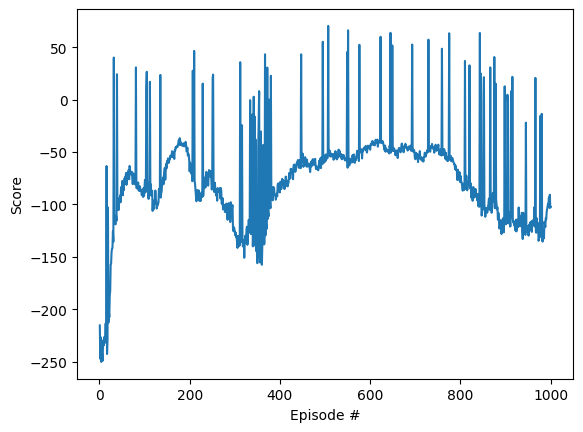

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

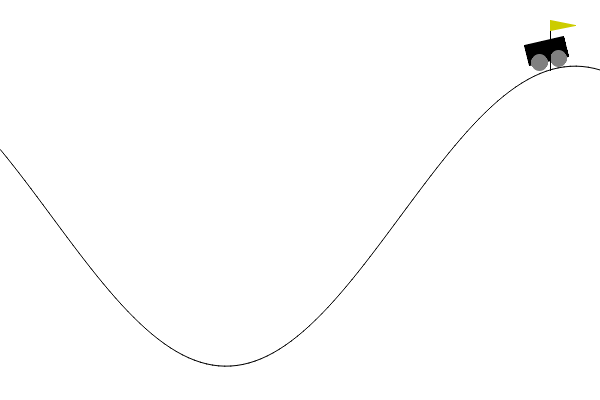

In [6]:
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")

state, _ = env.reset()
for t in range(1000):
    # clear frame
    display.clear_output(wait=True)

    action, _ = policy.select_action(state)

    # render game
    frame = env.render()
    display.display(Image.fromarray(frame))
    time.sleep(0.05)

    state, reward, done, _, _ = env.step([action])
    if done:
        break 

env.close()

### Discussion
What are the main problems of REINFORCE? There are three issues:

- The update process is very inefficient! We run the policy once, update once, and then throw away the trajectory.

- The gradient estimate $g$ is very noisy. By chance the collected trajectory may not be representative of the policy.

- There is no clear credit assignment. A trajectory may contain many good/bad actions and whether these actions are reinforced depends only on the final total output.